# Практическое задание 2. Диффузионные модели


## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного жёсткого срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи !!ВАЖНО!!!
Задания сдаются через систему google classroom. Посылка должна содержать:
* Ноутбук ddpm_hw_bmmo-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## В этом задании необходимо будет дореализовать ключевые формулы для обучения дискретной [ddpm](https://arxiv.org/pdf/2006.11239.pdf).  


---
Для выполнения домашнего задания достаточно использовать Google Colab.


In [1]:
!python3 -V
import torch

print(f'torch.__version__: {torch.__version__}')

Python 3.10.12
torch.__version__: 2.4.1+cu121


In [2]:
!pip3 install wandb torch_ema denoising_diffusion_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.8 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import random

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(42)

## Dataset

In [4]:
import numpy as np

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from typing import Generator, Tuple, Dict, Optional, Union
from torch import Tensor
from cv2 import resize


def preprocess_image(image: "PIL.Image") -> np.ndarray:
    image = np.array(image, dtype=np.uint8)
    image = resize(image, (32, 32))
    return np.array(image, dtype=np.float32) / 127.5 - 1


def postprocess_image(image: torch.Tensor) -> torch.Tensor:
    # convert values to [0; 255]
    image = image.cpu().detach()
    image = (image + 1) * 127.5
    image = torch.clip(image, 0, 255)
    return image


class MnistDataset(Dataset):
    def __init__(self, train: bool = True):
        super().__init__()
        self.mnist = MNIST(
            'data',
            train=train,
            download=True
        )

    def __len__(self) -> int:
        return len(self.mnist)

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        image, target = self.mnist[index]
        image = preprocess_image(image)
        target = int(target)
        return {
            "images": Tensor(image)[None],
            "targets": target
        }

In [5]:
def dict_to_device(dct: Dict[str, Tensor], device: torch.device) -> Dict[str, Tensor]:
    return {k: v.to(device) for k, v in dct.items()}


def get_train_images_generator(
    batch_size: int = 128,
    num_workers: int = 0,
    shuffle: bool = True,
    drop_last: bool = True
) -> Generator[Dict[str, Tensor], None, None]:
    dataset = MnistDataset(train=True)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        drop_last=drop_last
    )
    while True:
        yield from loader

In [6]:
def check_generator(batch_size: int = 128):
    generator = get_train_images_generator(batch_size)
    batch_dict = next(generator)
    assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
    assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)

check_generator(131)

<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-6-7f45e619ebd8>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['images'].shape == (batch_size, 1, 32, 32), batch_dict['images'].shape)
<ipython-input-6-7f45e619ebd8>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(batch_dict['targets'].shape == (batch_size,), batch_dict['targets'].shape)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 16162873.59it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 508362.61it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4451191.17it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 8162180.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## DDPM's dynamic, 5 pts



В `get_coeffs_primities` (2 pts) необходимо в возвращаеый словарь добавить рассчет коэффицентов, при помощи которых вы сможете реализовать семплирование из распределений $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$.

Например:
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha_t} = \prod_{t=1}^{T} \alpha_t$
- $\sqrt{\bar{\alpha_t}}$
- ...
- любые коэффиценты, которые помогут вам рассчитать коэффиценты в $q(x_t | x_0), q(x_t | x_{t+1}, x_0), p(x_t | x_{t + 1})$

`extract_values_from_times` - по батчу с целочислненными временами выдает батч коэфиицентов в нужном шейпе для перемножения с батчом картинок


In [7]:
from torch import nn


from typing import Dict
import torch
from torch import Tensor

def get_coeffs_primitives(
    T: int = 1000,
    beta_min: float = 1e-4,
    beta_max: float = 2e-2,
) -> Dict[str, Tensor]:
    """
    output: Dict[str, Tensor]
      {
        "a": b
      }
    ---
    b.shape == (T,)
    """
    betas = torch.linspace(beta_min, beta_max, T).float()
    alphas = 1 - betas
    sqrt_alphas = torch.sqrt(alphas)

    # Cumulative product of alphas
    alphas_hat = torch.cumprod(alphas, dim=0)

    # Previous alphas_hat (for t-1)
    alphas_hat_prev = torch.cat([torch.FloatTensor([1.]), alphas_hat[:-1]])
    sqrt_alphas_hat_prev = torch.sqrt(alphas_hat_prev)

    # Square root of cumulative products
    sqrt_alphas_hat = torch.sqrt(alphas_hat)
    sqrt_one_minus_alphas_hat = torch.sqrt(1 - alphas_hat)

    # Calculate additional coefficients for q(x_t | x_0), q(x_t | x_{t+1}, x_0), and p(x_t | x_{t+1})
    sqrt_recip_alphas_hat = torch.sqrt(1 / alphas_hat)
    sqrt_recipm1_alphas_hat = torch.sqrt(1 / alphas_hat - 1)

    # Coefficients for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = betas * (1 - alphas_hat_prev) / (1 - alphas_hat)
    posterior_log_variance_clipped = torch.log(torch.cat([posterior_variance[1:], posterior_variance[-1:]]))
    posterior_mean_coef1 = betas * sqrt_alphas_hat_prev / (1 - alphas_hat)
    posterior_mean_coef2 = sqrt_alphas * (1 - alphas_hat_prev) / (1 - alphas_hat)

    return {
        "betas": betas,
        "alphas": alphas,
        "sqrt_alphas": sqrt_alphas,
        "alphas_hat": alphas_hat,
        "alphas_hat_prev": alphas_hat_prev,
        "sqrt_alphas_hat": sqrt_alphas_hat,
        "sqrt_one_minus_alphas_hat": sqrt_one_minus_alphas_hat,
        "sqrt_recip_alphas_hat": sqrt_recip_alphas_hat,
        "sqrt_recipm1_alphas_hat": sqrt_recipm1_alphas_hat,
        "posterior_variance": posterior_variance,
        "posterior_log_variance_clipped": posterior_log_variance_clipped,
        "posterior_mean_coef1": posterior_mean_coef1,
        "posterior_mean_coef2": posterior_mean_coef2
    }


def extract_values_from_times(values: Tensor, times: torch.LongTensor) -> Tensor:
    values = values[times]
    return values[:, None, None, None]


`DDPMDynamic`: (3 pts)
- `__init__` - получаем коэффиценты, добавляем их в класс, как атрибуты, чтобы доставать их по имени без использования словаря
- `sample_from_posterior_q(x_t: FloatTensor, x_0: FloatTensor, t: LongTensor)` - $ x_{t-1} \sim q(x_{t-1} | x_{t}, x_0) $
- `forward` - $ x_{t} \sim q(x_t | x_0) $

In [8]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Dict

def extract_values_from_times(values: Tensor, times: Tensor) -> Tensor:
    return values[times]

class DDPMDynamic(nn.Module):
    def __init__(
        self,
        T: int = 1000,
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
    ):
        super().__init__()
        self.T = T
        coeffs_primitives = get_coeffs_primitives(T, beta_min, beta_max)
        for name, tensor in coeffs_primitives.items():
            self.register_buffer(name, tensor)

    def sample_time_on_device(self, batch_size: int = 1, device: torch.device = torch.device('cpu')):
        return torch.randint(0, self.T, (batch_size,), device=device)

    def sample_from_posterior_q(
        self,
        x_t: Tensor,
        x_0: Tensor,
        t: torch.LongTensor
    ) -> Tensor:
        # Extract necessary coefficients for the current time step
        posterior_mean_coef1 = extract_values_from_times(self.posterior_mean_coef1, t)
        posterior_mean_coef2 = extract_values_from_times(self.posterior_mean_coef2, t)
        posterior_variance = extract_values_from_times(self.posterior_variance, t)

        # Ensure that posterior_mean_coef1 and posterior_mean_coef2 are expanded to match the shape of x_0 and x_t
        posterior_mean_coef1_expanded = posterior_mean_coef1.view(-1, 1, 1, 1)
        posterior_mean_coef2_expanded = posterior_mean_coef2.view(-1, 1, 1, 1)

        # Perform the operation with expanded tensors
        posterior_mean = posterior_mean_coef1_expanded * x_0 + posterior_mean_coef2_expanded * x_t

        # Sample from the Gaussian distribution
        noise = torch.randn_like(x_t)

        # Ensure that posterior_variance is expanded to match the shape of noise
        posterior_variance_expanded = posterior_variance.view(-1, 1, 1, 1)

        # Perform the operation with expanded tensors
        x_t_prev = posterior_mean + torch.sqrt(posterior_variance_expanded) * noise

        return x_t_prev

    def forward(self, batch: Dict[str, Tensor]) -> Dict[str, Tensor]:

        x_0 = batch['x_0']
        t = batch['time']

        # Extract necessary coefficients for the current time step
        sqrt_alphas_hat = extract_values_from_times(self.sqrt_alphas_hat, t)
        sqrt_one_minus_alphas_hat = extract_values_from_times(self.sqrt_one_minus_alphas_hat, t)

        # Sample noise
        eps = torch.randn_like(x_0)

        # Calculate the noised sample
        x_t = sqrt_alphas_hat * x_0 + sqrt_one_minus_alphas_hat * eps

        return {
            "x_t": x_t,
            "eps": eps
        }


In [9]:
def check_ddpm_dynamic():
    dynamic = DDPMDynamic()
    device = torch.device('cuda:0')
    dynamic.to(device)
    times = dynamic.sample_time_on_device(10, device)
    assert times.device == device, f'{times.device}, {device}'
    assert times.shape == (10,)

check_ddpm_dynamic()

### `Sampler`/DDPM's cycle: (1.5 pts)
- `single_step` - необходимо просемплировать $x_{t-1} \sim p(x_{t-1}|x_t)$
- `sample` - весь процесс обхода по марковской цепочки семплирования

In [10]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple

class Sampler(nn.Module):
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic
    ):
        super().__init__()
        ddpm.eval()
        self.ddpm = ddpm
        self.dynamic = dynamic

    @torch.no_grad()
    def single_step(self, x_t: Tensor, t: Tensor) -> Tensor:
        # Predict the noise added at time t using the DDPM model
        predicted_noise = self.ddpm(x_t, t)

        # Estimate x_0 from x_t and predicted noise
        sqrt_recip_alphas_hat = extract_values_from_times(self.dynamic.sqrt_recip_alphas_hat, t)
        sqrt_recipm1_alphas_hat = extract_values_from_times(self.dynamic.sqrt_recipm1_alphas_hat, t)

        # Ensure that sqrt_recip_alphas_hat and sqrt_recipm1_alphas_hat are expanded to match the shape of x_t
        sqrt_recip_alphas_hat_expanded = sqrt_recip_alphas_hat.view(-1, 1, 1, 1)
        sqrt_recipm1_alphas_hat_expanded = sqrt_recipm1_alphas_hat.view(-1, 1, 1, 1)

        # Perform the operation with expanded tensors
        x_0_estimate = sqrt_recip_alphas_hat_expanded * x_t - sqrt_recipm1_alphas_hat_expanded * predicted_noise

        x_t_prev = self.dynamic.sample_from_posterior_q(x_t, x_0_estimate, t)


        return x_t_prev


    @torch.no_grad()
    def sample(
        self,
        shape: Tuple[int, int, int, int],
        device: torch.device = torch.device('cpu'),
        verbose: bool = False
    ) -> Tensor:
        self.ddpm.eval()
        x_t = torch.randn(shape, device=device)
        batch_size = shape[0]

        bar = trange if verbose else range
        for t in bar(self.dynamic.T - 1, -1, -1):
            t_tensor = torch.ones(batch_size, dtype=torch.int64, device=device) * t
            x_t = self.single_step(x_t, t_tensor)
        return x_t


###При помощи примитивов сверху реализовать обучение ddpm.


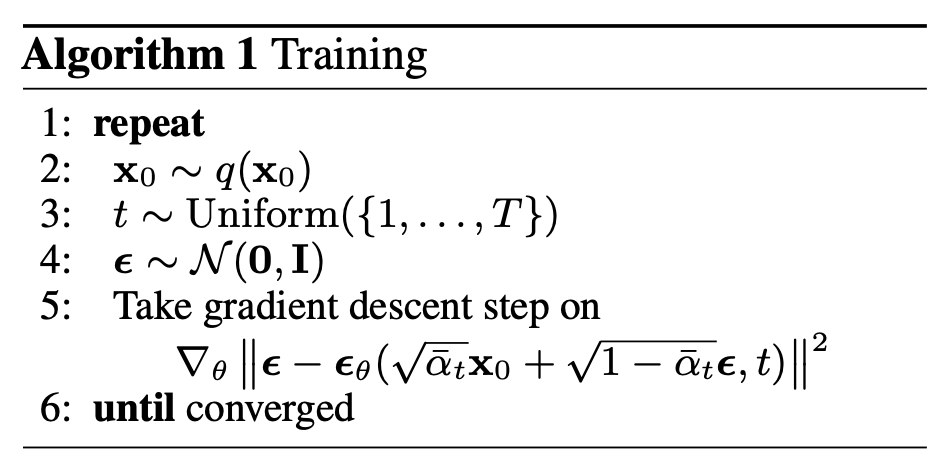


`DiffusionTrainer`: (1.5 pts)
- `calc_loss(clean_images: FloatTensor)` - необходимо внутри метода просемплировать время, далее просемплировать $x_t$, обработать батч, рассчитать лосс для обучения

In [11]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Union, Dict, Generator
from tqdm import trange
import wandb
import torchvision
import numpy as np
from torch_ema import ExponentialMovingAverage
import wandb
import math
import torchvision

class DiffusionTrainer:
    def __init__(
        self,
        ddpm: nn.Module,
        dynamic: DDPMDynamic,
        device: torch.device = torch.device('cpu')
    ):
        self.ddpm = ddpm
        self.dynamic = dynamic
        self.dynamic.to(device)
        self.ddpm.to(device)
        self.sampler = Sampler(ddpm, dynamic)
        self.sampler.to(device)
        self.ema = ExponentialMovingAverage(ddpm.parameters(), decay=0.999)
        self.device = device
        self.optimizer = torch.optim.AdamW(
            self.ddpm.parameters(),
            lr=2e-4,
            weight_decay=1e-2
        )
        self.step = 0

    def switch_to_ema(self) -> None:
        self.ema.store(self.ddpm.parameters())
        self.ema.copy_to(self.ddpm.parameters())

    def switch_back_from_ema(self) -> None:
        self.ema.restore(self.ddpm.parameters())

    def calc_loss(self, x_0: torch.Tensor) -> torch.Tensor:
        batch_size = x_0.size(0)

        # Sample random times t for each example in the batch
        t = torch.randint(0, self.dynamic.T, (batch_size,), device=self.device)

        # Get coefficients for the sampled times
        sqrt_alphas_hat_t = self.dynamic.sqrt_alphas_hat[t]
        sqrt_one_minus_alphas_hat_t = self.dynamic.sqrt_one_minus_alphas_hat[t]

        # Sample noise to add to x_0
        noise = torch.randn_like(x_0)

        sqrt_alphas_hat_t = sqrt_alphas_hat_t.view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_hat_t = sqrt_one_minus_alphas_hat_t.view(-1, 1, 1, 1)


        # Create x_t from x_0 and noise using forward diffusion process
        x_t = sqrt_alphas_hat_t * x_0 + sqrt_one_minus_alphas_hat_t * noise

        # Predict noise using DDPM model
        predicted_noise = self.ddpm(x_t, t)

        # Calculate MSE loss between predicted noise and actual noise
        loss = nn.functional.mse_loss(predicted_noise, noise)

        return loss


    def log_metric(self, metric_name: str, loader_name: str, value: Union[float, torch.Tensor, wandb.Image]):
        wandb.log({f'{metric_name}/{loader_name}': value}, step=self.step)

    def optimizer_logic(self, loss: torch.Tensor) -> None:
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.ema.update(self.ddpm.parameters())

    def train(
            self,
            train_generator: Generator[Dict[str, Tensor], None, None],
            total_iters: int = 1000,
            project_name: str = 'discrete_time_ddpm',
            experiment_name: str = 'mnist_baseline'
    ) -> None:
        session = wandb.init(project=project_name, name=experiment_name)
        self.ddpm.train()
        for iter_idx in trange(1, 1 + total_iters):
            self.step = iter_idx
            batch = next(train_generator)
            batch = dict_to_device(batch, device=self.device)
            loss = self.calc_loss(x_0=batch['images'])
            self.log_metric('mse', 'train', loss)
            self.optimizer_logic(loss)
            if iter_idx % 1000 == 0:
                self.snapshot()
        self.ddpm.eval()
        self.switch_to_ema()
        session.finish()

    @torch.no_grad()
    def sample_images(
            self, batch_size: int,
            verbose: bool = False

    ) -> torch.Tensor:
        x_pred = self.sampler.sample((batch_size, 1, 32, 32), self.device, verbose)
        x_pred = postprocess_image(x_pred)
        return x_pred

    @torch.no_grad()
    def snapshot(self) -> None:
        prev_mode = self.ddpm.training
        self.ddpm.eval()
        self.switch_to_ema()
        images = self.sample_images(100).cpu()
        nrow = 10
        grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
        grid = grid.data.numpy().astype(np.uint8)
        self.log_metric('images', 'from_noise', wandb.Image(grid))
        self.switch_back_from_ema()
        self.ddpm.train(prev_mode)


In [12]:
from denoising_diffusion_pytorch import Unet

set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [13]:
device = torch.device('cuda:0')

In [14]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [15]:
generator = get_train_images_generator(128)

In [16]:
trainer.train(
    generator,
    total_iters=5000
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/5000 [00:00<?, ?it/s]/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  0%|          | 1/5000 [00:03<4:39:05,  3.35s/it]/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
100%|██████████| 5000/5000 [45:34<00:00,  1.83it/s]


mse/train,▆█▅▅▅▅▄▄▄▃▃▃▂▃▂▃▃▃▃▂▃▂▄▁▂▁▃▃▂▂▃▂▂▂▂▃▁▂▁▁
mse/train,0.02344


Вы обучили большую модель, самое важное ее сохранить и не потерять!!!

In [17]:
trainer.switch_to_ema()
torch.save(ddpm.state_dict(), "./pretrained_ddpm_checkpoint.pth")

#### Безусловная генерация (неплохих картинок - 1 pts)

In [18]:
# from google.colab import files

# # Скачивание файла
# files.download('./pretrained_ddpm_checkpoint.pth')

100%|██████████| 1000/1000 [01:45<00:00,  9.50it/s]


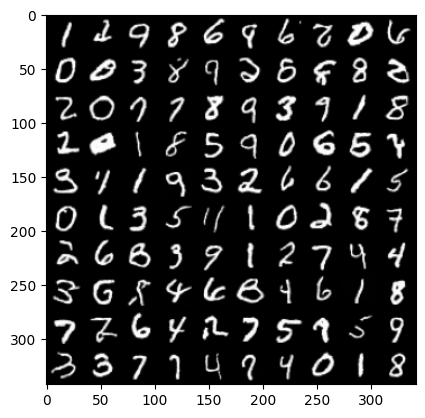

In [19]:
from matplotlib import pyplot as plt
import math


def sample_images(
    sampler: Sampler, batch_size: int == 100,
    device = torch.device('cpu'),
    verbose: bool = True
):
    images = sampler.sample((batch_size, 1, 32, 32), device, True)
    images = postprocess_image(images)
    images = images.cpu()
    nrow = int(math.ceil(math.sqrt(batch_size)))
    grid = torchvision.utils.make_grid(images, nrow=nrow).permute(1, 2, 0)
    grid = grid.data.numpy().astype(np.uint8)
    return grid

grid = sample_images(trainer.sampler, 100, trainer.device)

plt.imshow(grid)

### Опишите ваши выводы/результаты: (1 pts)


Описание результатов:

1. Качество генерации:

   • Цифры выглядят отчетливыми и достаточно реалистичными для человекомашинно написанных.

   • Однако могут быть некоторые искажения или нечеткости, что свойственно генеративным моделям, особенно на начальных этапах обучения или при недостаточных данных.

2. Разнообразие:

   • Сетку составляют разные цифры, демонстрируя способность модели генерировать разнообразные образцы.

3. Четкость:

   • Общая четкость цифр достаточно высокая, что свидетельствует о хорошей работе модели в восстановлении деталей.

Модель способна генерировать визуально узнаваемые и разнообразные цифры.

# Оценка качества (2 pts)

Для оценки качества часто используют метрику FID (Freche Inception Distance), чем ниже FID между двумя наборами изображений, тем более они похожи. На практике мерят FID между выборками одинакового размера, а в качестве эталонной выборки используют обучающую. Вам необходимо посчитать FID для 200, 1_000, 5_000, 8_000 и 10_000 изображений.

Эталоном считается FID посчитанный на выборках размера 50_000 изображений, но это слишком долго в рамках учебной задачи.

Идейно FID равен расстоянию Фреше (расстоянию между двумя нормальными распределениями) в латентном пространстве хорошего классификатора (Inception V3).

Для подсчета метрики, можно использовать [библиотечную реализацию](https://github.com/mseitzer/pytorch-fid)

**Подсказка**

Вы можете сразу сгенерировать 10_000 изображений, а потом аккуратно брать нужное количество для экономии времени.


In [20]:
!pip install pytorch-fid

In [21]:
import os
import PIL

from tqdm import tqdm
from pytorch_fid.fid_score import calculate_fid_given_paths

In [22]:
set_global_seed(42)

ddpm = Unet(
    dim=64,
    dim_mults=(1, 2, 4, 4),
    channels=1,
    flash_attn=True
)

In [23]:
checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")

ddpm.load_state_dict(checkpoint)
ddpm.eval()

<ipython-input-23-4f33fb3e246d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./pretrained_ddpm_checkpoint.pth")


Unet(
  (init_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=128, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): RMSNorm()
          (act): SiLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (res_conv): Identity()
      )
      (2): Line

In [24]:
device = torch.device('cuda:0')

In [25]:
trainer = DiffusionTrainer(
    ddpm,
    DDPMDynamic(),
    device
)

In [26]:
@torch.no_grad()
def gen_imgs(
    sampler: Sampler,
    folder: str,
    device=torch.device('cuda:0'),
    count: int = 1_000,
    batch_size: int = 100,
    seed: int = 42
):

    set_global_seed(seed)
    os.makedirs(folder, exist_ok=True)
    iter_num = count // batch_size + int(count % batch_size > 0)

    for _ in range(iter_num):

        already_sampled = len(os.listdir(folder))
        bs = min(batch_size, count - already_sampled)

        images = sampler.sample((bs, 1, 32, 32), device, True)
        images = postprocess_image(images)
        images = images.cpu().permute(0, 2, 3, 1).numpy().astype('uint8')

        for i in range(images.shape[0]):
            index = already_sampled + i

            file_name = os.path.join(folder, f'img_{index:05d}.png')
            PIL.Image.fromarray(images[i, :, :, 0], 'L').save(file_name)

In [27]:
def extract_dataset(folder: str, count: int = 1_000):

    os.makedirs(folder, exist_ok=True)
    data = MnistDataset()

    for i in range(count):
        img = data[i]['images']
        img = postprocess_image(img)
        img = img.cpu().permute(1, 2, 0).numpy().astype('uint8')

        file_name = os.path.join(folder, f'img_{i:05d}.png')
        PIL.Image.fromarray(img[:, :, 0], 'L').save(file_name)

In [28]:
extract_dataset("./mnist_data_img")

In [29]:
# Долгая функция

gen_imgs(trainer.sampler, "./mnist_gen_img")

100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]


**Функция работала очень долго и не успела выполниться до истечения лимита в Colab**

In [30]:
path_dataset = 'mnist_data_img'
path_output  = 'mnist_gen_img'


fid = calculate_fid_given_paths(
        [path_dataset, path_output],
        batch_size=100,
        device=device,
        dims=2048,
        num_workers=12
    )

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 133MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Нарисуйте график значения FID в зависимости от размера выборок. Учтите, что для корректной работы выборки должны быть одинакового размера. Какие выводы вы можете сделать?

In [31]:
fid

14.474862446027515

**Вывод: Значение FID 14.47 указывает на достаточно хорошее качество генерируемых изображений. В контексте оценки качества изображений, чем ниже значение FID, тем ближе распределение генерируемых изображений к распределению реальных изображений. Хотя идеальным считается FID ниже 10, значение 14.47 свидетельствует о приемлемом качестве, особенно если учесть сложность задачи и размер обучающего набора данных.**